Time-Series Prediction
Time series and sequence prediction could be a really amazing to predict/estimate a robot's trajectory which requires temporal data at hand. In this assignemnt we will see how this could be done using Deep Learning.

Given a dataset [link](https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv) for airline passengers prediction problem. Predict the number of international airline passengers in units of 1,000 given a year and a month.
Here is how the data looks like.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

file_names = ['Rpm40ex.csv', 'Rpm60ex.csv', 'Rpm80ex.csv', 'Rpm120ex.csv', 'Rpm140ex.csv','Rpm160ex.csv'] # dataset path

folder = glob.glob(os.path.join('/home/sj/Desktop/RNN/simulational_updated/training', '*.csv'))
input_speeds = [40, 60, 80, 120, 140, 160]

print(folder)
dataframe = []
# Reading data using pandas or csv
for file_name in folder:
  # print(file_name)
  df = pd.read_csv(file_name)
  dataframe.append(df)
print(df.columns)
print(len(dataframe))

['/home/sj/Desktop/RNN/simulational_updated/training/Rpm140ex.csv', '/home/sj/Desktop/RNN/simulational_updated/training/Rpm60ex.csv', '/home/sj/Desktop/RNN/simulational_updated/training/Rpm80ex.csv', '/home/sj/Desktop/RNN/simulational_updated/training/Rpm120ex.csv', '/home/sj/Desktop/RNN/simulational_updated/training/Rpm160ex.csv', '/home/sj/Desktop/RNN/simulational_updated/training/Rpm40ex.csv']
Index(['Time ', 'H ', 'U ', 'Output Speed ', 'Weight on bit'], dtype='object')
6


In [2]:
for data in dataframe:
  print(data.head())

   Time           H         U   Output Speed   Weight on bit
0  50.00  514.743369  1.715520     125.518922     468.163337
1  50.01  494.416268  1.715844     133.573073     449.086239
2  50.02  478.340542  1.716188     142.162345     437.610829
3  50.03  468.991990  1.716553     150.625272     422.252976
4  50.04  468.681662  1.716938     158.286405     427.989533
   Time           H         U   Output Speed   Weight on bit
0  50.00  632.982341  0.710433      51.705216     589.850094
1  50.01  625.360042  0.710567      53.150475     582.374487
2  50.02  616.735896  0.710704      54.776062     570.735495
3  50.03  607.124504  0.710846      56.589190     562.479218
4  50.04  596.560271  0.710992      58.589987     552.192580
   Time           H         U   Output Speed   Weight on bit
0  50.00  494.140899  0.963700     108.350680     450.541721
1  50.01  480.788153  0.963976     112.808266     436.525781
2  50.02  471.614011  0.964261     116.348315     427.028653
3  50.03  467.677072  0.

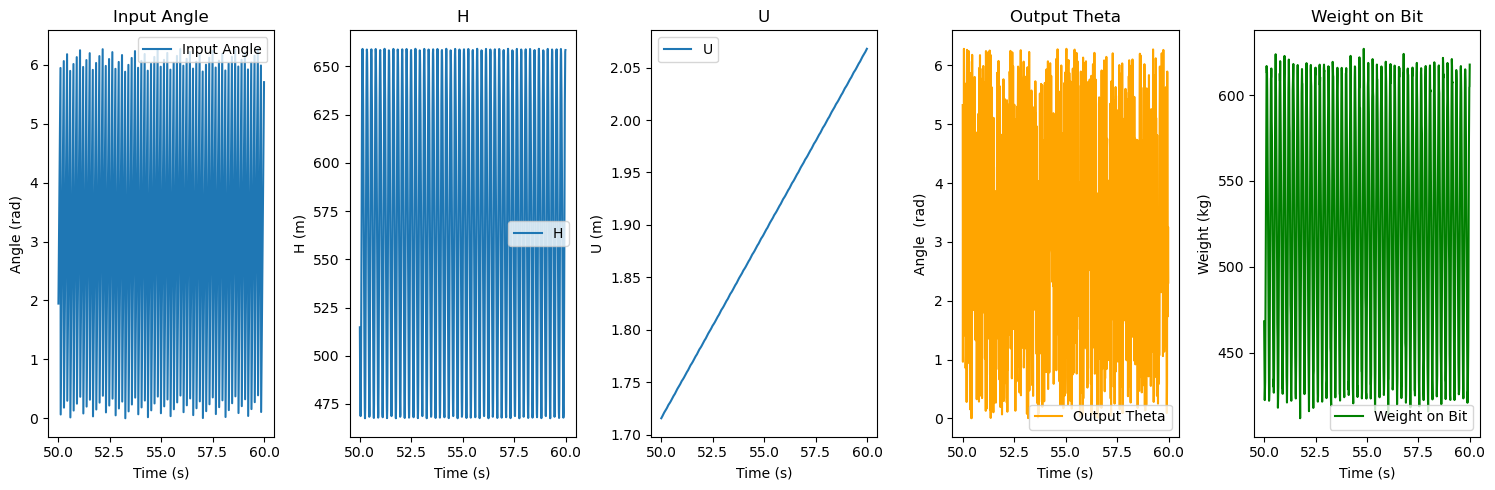

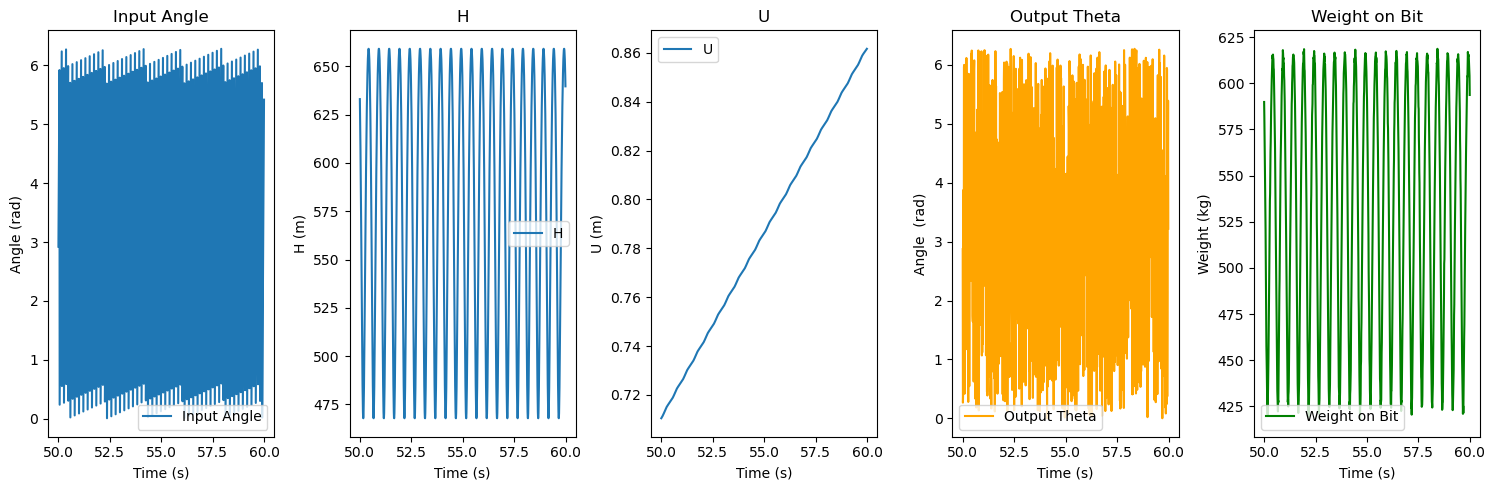

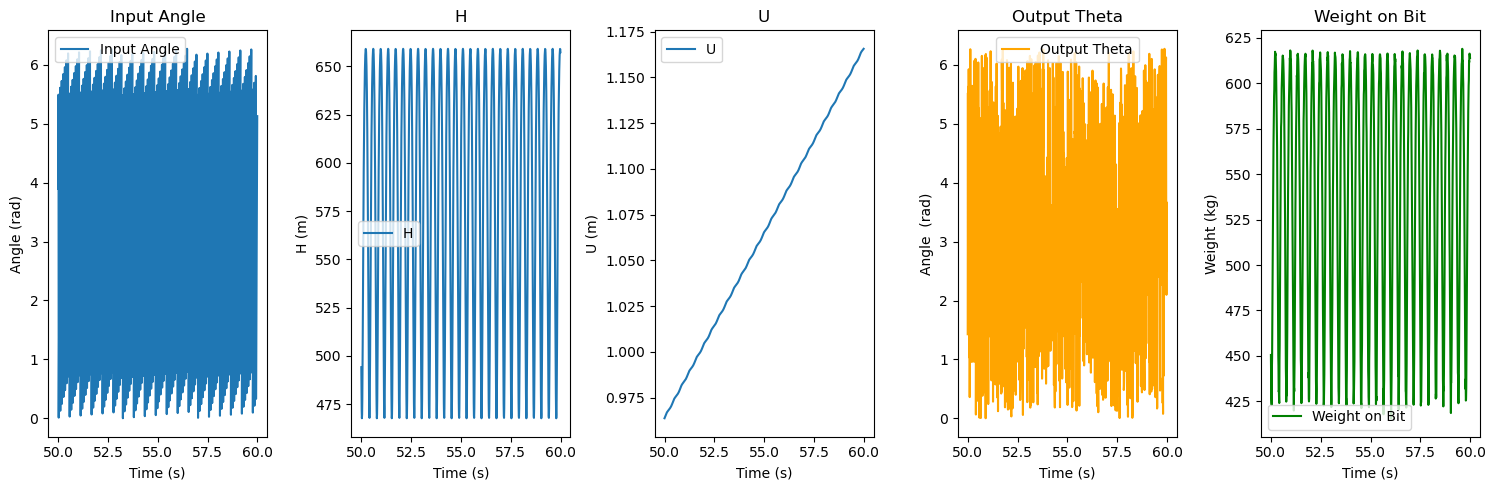

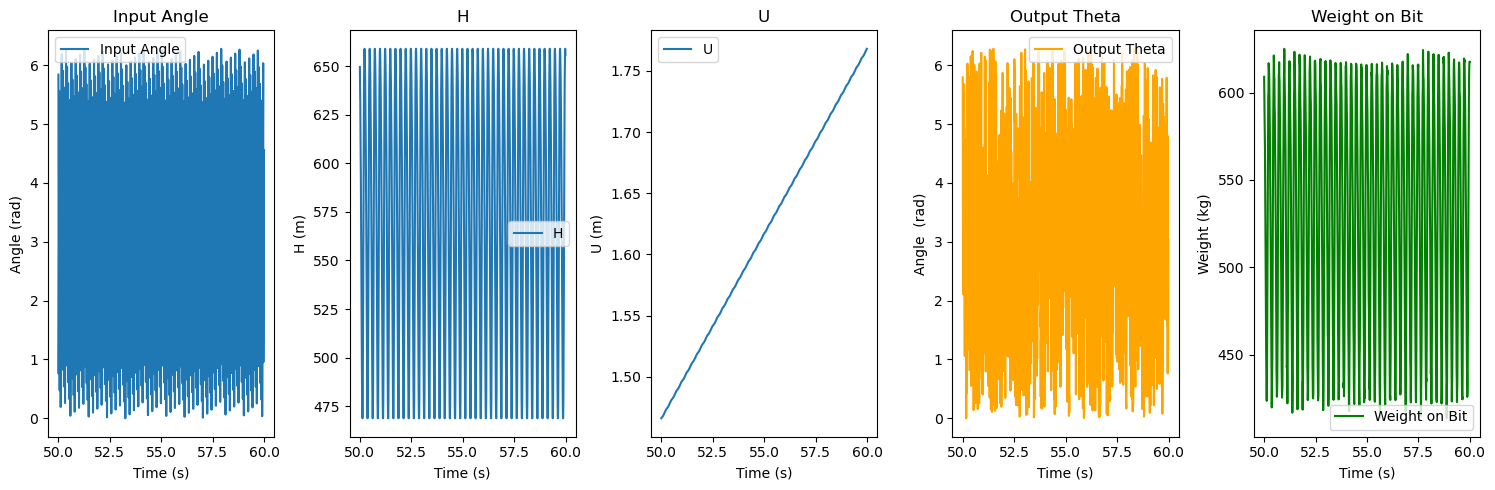

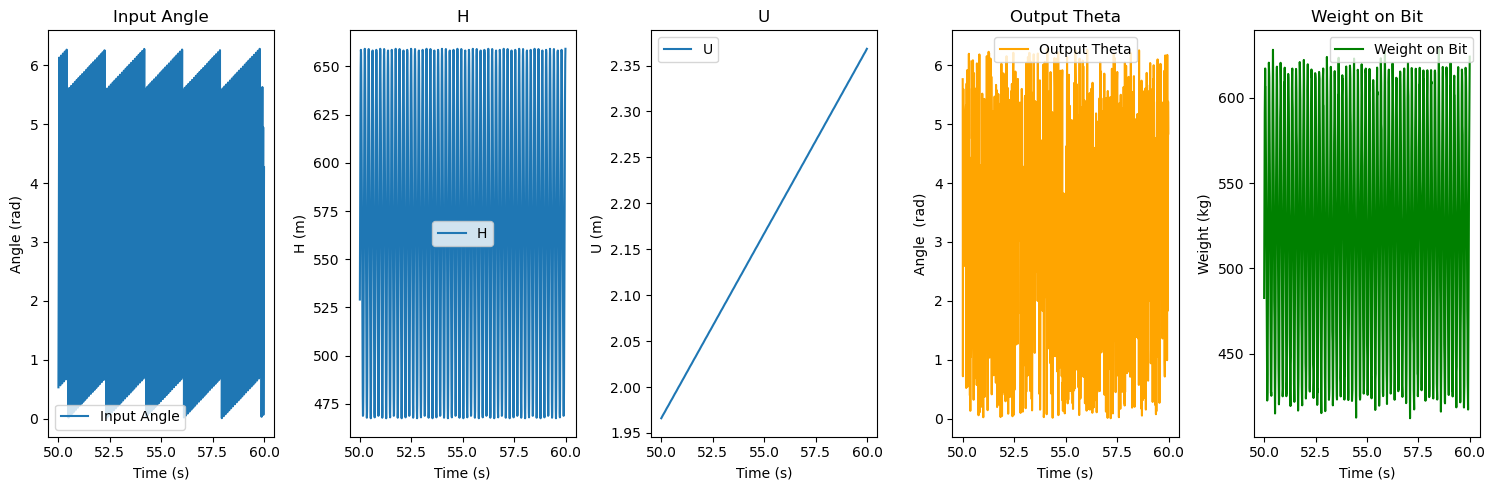

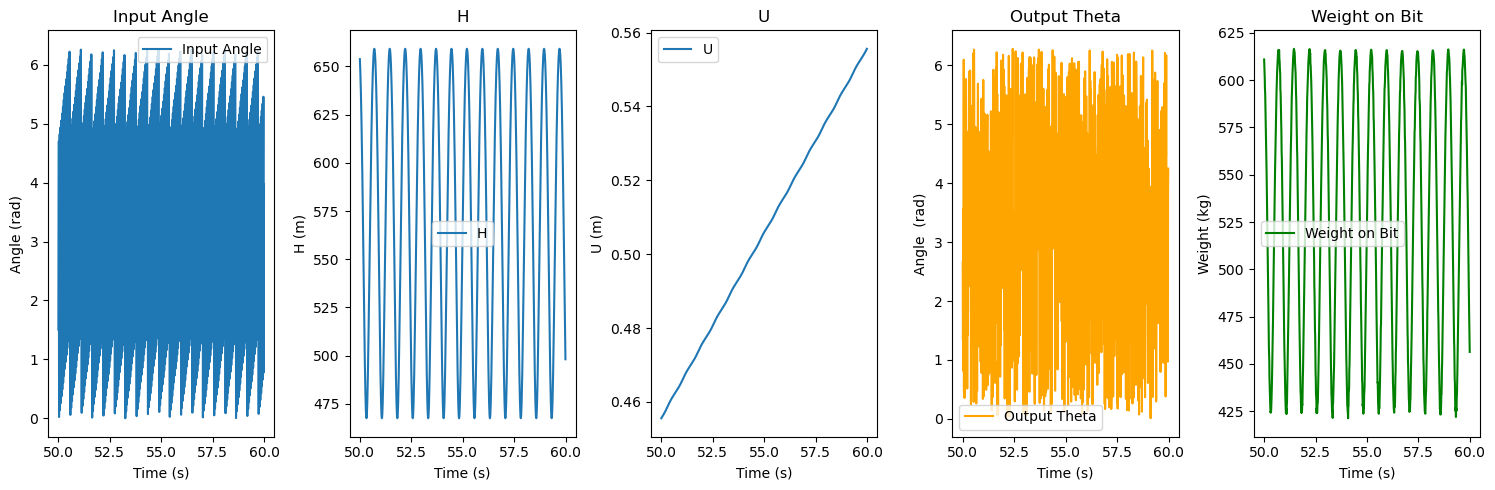

In [3]:
import numpy as np
for df, input_speed in zip(dataframe, input_speeds):
  time = df[["Time "]].values.astype('float32')

  output_speed = df[["Output Speed "]].values.astype('float32')

  H = df[["H "]].values.astype('float32')

  U =  df[["U "]].values.astype('float32')

  output_theta = np.mod(output_speed*time, 2*np.pi)

  inputs = np.full(len(output_speed), input_speed).astype('float32')
  inputs = inputs.reshape(len(inputs), 1)
  # print(inputs.shape)

  df["Input Speed "] = inputs

  input_theta = np.mod(inputs*time, 2*np.pi)

  # display = np.concatenate((output_theta, output_speed, time), axis=1)

  # print(display.shape)

  weight_on_bit = df[["Weight on bit"]].values.astype('float32')

  upto = 1000
  H = H[:upto]
  U = U[:upto]
  output_speed = output_speed[:upto]
  weight_on_bit = weight_on_bit[:upto]
  output_theta = output_theta[:upto]
  time = time[:upto]
  inputs = inputs[:upto]
  input_theta = input_theta[:upto]

  # Plot the dataset
  fig, axs = plt.subplots(1, 5, figsize=(15, 5))

  # Plot Input Angle
  axs[0].plot(time, input_theta, label= 'Input Angle')
  axs[0].set_title('Input Angle')
  axs[0].set_xlabel('Time (s)')
  axs[0].set_ylabel('Angle (rad)')
  axs[0].legend()

  # Plot H
  axs[1].plot(time, H, label= 'H')
  axs[1].set_title('H')
  axs[1].set_xlabel('Time (s)')
  axs[1].set_ylabel('H (m)')
  axs[1].legend()

  # Plot U
  axs[2].plot(time, U, label= 'U')
  axs[2].set_title('U')
  axs[2].set_xlabel('Time (s)')
  axs[2].set_ylabel('U (m)')
  axs[2].legend()

  # Plot Output Angle
  axs[3].plot(time, output_theta, label='Output Theta', color='orange')
  axs[3].set_title('Output Theta')
  axs[3].set_xlabel('Time (s)')
  axs[3].set_ylabel('Angle  (rad)')
  axs[3].legend()

  # Plot Weight on Bit
  axs[4].plot(time, weight_on_bit, label='Weight on Bit', color='green')
  axs[4].set_title('Weight on Bit')
  axs[4].set_xlabel('Time (s)')
  axs[4].set_ylabel('Weight (kg)')
  axs[4].legend()

  # Adjust layout and show the plots
  plt.tight_layout()
  plt.show()

# **Pytorch LSTM Implementation**


# Pre-Processing the Training Data

In [24]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

features = []

for filename, input_speed in zip(file_names, input_speeds):

  # plotting the dataset
  time = df[["Time "]].values.astype('float32')
  output_speed = df[["Output Speed "]].values.astype('float32')
  # print(output_speed.shape)

  inputs = np.full(len(output_speed), input_speed, dtype=np.float32)
  inputs = inputs.reshape(len(inputs), 1)

  input_theta = np.mod(inputs*time, 2*np.pi)

  output_theta = np.mod(output_speed*time, 2*np.pi)

  H = df[["H "]].values.astype('float32')

  U = df[["U "]].values.astype('float32')

  # print(inputs.shape)
  df["Input Speed "] = inputs
  
  weight_on_bit = df[["Weight on bit"]].values.astype('float32')

  upto = 1000
  H = H[:upto]
  U = U[:upto]
  output_speed = output_speed[:upto]
  weight_on_bit = weight_on_bit[:upto]
  time = time[:upto]
  inputs = inputs[:upto]
  output_theta = output_theta[:upto]
  input_theta = input_theta[:upto]

  features.append(np.concatenate((np.array(input_theta), np.array(H), np.array(U), np.array(output_theta), np.array(weight_on_bit)), axis=1))

features = np.array(features)

# print(features.shape)
# print(features)
features = np.reshape(features,  ((features.shape[0]*features.shape[1]), features.shape[2]))
print(features.shape)

from sklearn.preprocessing import MinMaxScaler
feature_scaler = MinMaxScaler(feature_range=(0,1))
scaled_features = feature_scaler.fit_transform(features)

# Convert the NumPy array to a PyTorch tensor
Training_set = torch.from_numpy(scaled_features)

print("=================Creating_Dataset==================\n", Training_set.shape, "\n")

set_to_scale_features = []
set_to_scale_labels = []

# # Loop through the array to create the feature and label sets
for i in range(30, Training_set.shape[0]):
    set_to_scale_features.append(Training_set[i-30:i, [0, 1, 2]].cpu().numpy())
    set_to_scale_labels.append(Training_set[i, [3, 4]].cpu().numpy())

# # Convert lists to NumPy arrays
set_to_scale_features = np.array(set_to_scale_features)
set_to_scale_labels = np.array(set_to_scale_labels)


print("=================Creating Features and Labels==================\n", set_to_scale_features.shape, "\n", set_to_scale_labels.shape, "\n" )

# # Reshape the feature set
X_train = torch.from_numpy(set_to_scale_features)

# # Convert labels to PyTorch tensor
Y_train = torch.from_numpy(set_to_scale_labels.reshape(set_to_scale_labels.shape[0], 2))

print("=================Converting Features and Labels to Tensors==================\n", X_train.shape, "\n", Y_train.shape, "\n" )

# print(X_train)

(6000, 5)
=================Creating_Dataset==================
 torch.Size([6000, 5]) 

=================Creating Features and Labels==================
 (5970, 30, 3) 
 (5970, 2) 

=================Converting Features and Labels to Tensors==================
 torch.Size([5970, 30, 3]) 
 torch.Size([5970, 2]) 



In [25]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

df = pd.read_csv('/home/sj/Desktop/RNN/simulational_updated/testing/Rpm100ex.csv')
time = df[["Time "]].values.astype('float32')
H = df[["H "]].values.astype('float32')
U = df[["U "]].values.astype('float32')
output_speed = df[["Output Speed "]].values.astype('float32')
weight_on_bit = df[["Weight on bit"]].values.astype('float32')

inputs = np.full(len(output_speed), 100, dtype=np.float32)
inputs = inputs.reshape(len(inputs), 1)
df["Input Speed "] = inputs

output_theta = np.mod(output_speed*time, 2*np.pi)
input_theta = np.mod(inputs*time, 2*np.pi)

upto = 1000
H = H[:upto]
U = U[:upto]
output_speed = output_speed[:upto]
weight_on_bit = weight_on_bit[:upto]
time = time[:upto]
inputs = inputs[:upto]
output_theta = output_theta[:upto]
input_theta = input_theta[:upto]

test_features = np.concatenate((np.array(input_theta), np.array(H), np.array(U),  np.array(output_theta), np.array(weight_on_bit)), axis=1)

# print(test_features)
# print(test_features.shape)
scaled_test_features = feature_scaler.transform(test_features)

# Convert the NumPy array to a PyTorch tensor
Testing_set = torch.from_numpy(scaled_test_features).to(device)

print("=================Creating_Dataset==================\n", Testing_set.shape, "\n")

set_to_scale_test_features = []
set_to_scale_test_labels = []

# # Loop through the array to create the feature and label sets
for i in range(30, Testing_set.shape[0]):
    set_to_scale_test_features.append(Testing_set[i-30:i, [0, 1, 2]].cpu().numpy())
    set_to_scale_test_labels.append(Testing_set[i, [3, 4]].cpu().numpy())

# # Convert lists to NumPy arrays
set_to_scale_test_features = np.array(set_to_scale_test_features)
set_to_scale_test_labels = np.array(set_to_scale_test_labels)


print("=================Creating Features and Labels==================\n", set_to_scale_test_features.shape, "\n", set_to_scale_test_labels.shape, "\n" )

# # Reshape the feature set
X_test = torch.from_numpy(set_to_scale_test_features)

# # Convert labels to PyTorch tensor
Y_test = torch.from_numpy(set_to_scale_test_labels.reshape(set_to_scale_test_labels.shape[0], 2))

print("=================Converting Features and Labels to Tensors==================\n", X_test.shape, "\n", Y_test.shape, "\n" )

# print(X_test)

=================Creating_Dataset==================
 torch.Size([1000, 5]) 

=================Creating Features and Labels==================
 (970, 30, 3) 
 (970, 2) 

=================Converting Features and Labels to Tensors==================
 torch.Size([970, 30, 3]) 
 torch.Size([970, 2]) 



In [26]:
# # Creating dataset objects to process nn data through pytorch
from torch.utils.data import Dataset

class TSA(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __getitem__(self, index) :
    return self.X[index], self.Y[index]

  def __len__(self):
    return len(self.X)

train_dataset = TSA(X_train, Y_train)
test_dataset = TSA(X_test, Y_test)

# train_dataset

# # Using data_loader to classify data in required format
from torch.utils.data import DataLoader

batch_size = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Print the batch sizes to confirm
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([100, 30, 3]) torch.Size([100, 2])


# LSTM Training

In [32]:
import numpy as np
import torch
import torch.nn as nn

# Define the hyperparameters
input_size = 3
hidden_size = 240
num_stacked_layers = 5
fc_size1 = 280
fc_size2 = 360
fc_size3 = 640
output_size = 2
dropout = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResidualLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.residual = nn.Linear(input_size, hidden_size) if input_size != hidden_size else nn.Identity()

    def forward(self, x):
        residual = self.residual(x)
        out, (hn, cn) = self.lstm(x)
        return out + residual, (hn, cn)

class ResidualFC(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.residual = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = self.residual(x)
        out = self.fc(x)
        return self.relu(out + residual)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # Stacked LSTM layers with residual connections
        self.lstm_layers = nn.ModuleList([
            ResidualLSTM(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_stacked_layers)
        ])

        self.dropout = nn.Dropout(dropout)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Tanh()
        )

        # Separate fully connected layers for each output with residual connections
        self.fc_output1 = nn.Sequential(
            ResidualFC(hidden_size, fc_size1),
            ResidualFC(fc_size1, fc_size2),
            ResidualFC(fc_size2, fc_size3),
            nn.Linear(fc_size3, 1)
        )

        self.fc_output2 = nn.Sequential(
            ResidualFC(hidden_size, fc_size1),
            ResidualFC(fc_size1, fc_size2),
            ResidualFC(fc_size2, fc_size3),
            nn.Linear(fc_size3, 1)
        )

    def forward(self, x):
        # Process through LSTM layers
        for lstm_layer in self.lstm_layers:
            x, _ = lstm_layer(x)

        # Apply attention mechanism
        attention_weights = self.attention(x).squeeze(-1)
        attention_weights = torch.softmax(attention_weights, dim=1)
        x_weighted = torch.sum(x * attention_weights.unsqueeze(-1), dim=1)

        x = self.dropout(x_weighted)

        # Apply separate fully connected layers for each output
        output1 = self.fc_output1(x)
        output2 = self.fc_output2(x)

        # Concatenate the outputs
        return torch.cat((output1, output2), dim=1)

# Initialize the model
model = LSTMModel(input_size, hidden_size, num_stacked_layers, dropout, output_size=output_size)
model.to(device)

# Print model summary
print(model)

LSTMModel(
  (lstm_layers): ModuleList(
    (0): ResidualLSTM(
      (lstm): LSTM(3, 240, batch_first=True)
      (residual): Linear(in_features=3, out_features=240, bias=True)
    )
    (1-4): 4 x ResidualLSTM(
      (lstm): LSTM(240, 240, batch_first=True)
      (residual): Identity()
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (attention): Sequential(
    (0): Linear(in_features=240, out_features=1, bias=True)
    (1): Tanh()
  )
  (fc_output1): Sequential(
    (0): ResidualFC(
      (fc): Linear(in_features=240, out_features=280, bias=True)
      (residual): Linear(in_features=240, out_features=280, bias=True)
      (relu): ReLU()
    )
    (1): ResidualFC(
      (fc): Linear(in_features=280, out_features=360, bias=True)
      (residual): Linear(in_features=280, out_features=360, bias=True)
      (relu): ReLU()
    )
    (2): ResidualFC(
      (fc): Linear(in_features=360, out_features=640, bias=True)
      (residual): Linear(in_features=360, out_features=640, bias=True)

In [33]:
import torch.optim as optim
learning_rate = 0.001
num_epochs = 50

best_val_loss = float('inf')
patience = 10
counter = 0

val_loss_list = []

# Define your loss function
loss_function = nn.MSELoss()

# Define your optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Running epochs
for epoch in range(num_epochs):
    # Set model to training mode
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(batch_index)
        if batch_index % 2 == 1:
          avg_loss_across_batches = running_loss / 100
          print('Batch {0}, Loss: {1: .6f}, Epoch: {2}'.format(batch_index+1, avg_loss_across_batches, epoch+1))

    # Validate every epoch
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
          output = model(x_batch)
          loss = loss_function(output, y_batch)
          running_loss += loss

    val_loss = running_loss / len(test_loader)
    print('Validation Loss {0: .3f}'.format(val_loss))

    print('###################################################')

    running_loss = 0.0

    val_loss_list.append(val_loss)
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping, stopping at epoch no. {epoch+1}")
            print(val_loss_list)
            print("Best_Validation_Loss", best_val_loss)
            break


Epoch: 1
Batch 2, Loss:  0.007447, Epoch: 1
Batch 4, Loss:  0.010543, Epoch: 1
Batch 6, Loss:  0.013341, Epoch: 1
Batch 8, Loss:  0.015740, Epoch: 1
Batch 10, Loss:  0.017883, Epoch: 1
Batch 12, Loss:  0.019937, Epoch: 1
Batch 14, Loss:  0.022443, Epoch: 1
Batch 16, Loss:  0.024335, Epoch: 1
Batch 18, Loss:  0.026448, Epoch: 1
Batch 20, Loss:  0.028405, Epoch: 1
Batch 22, Loss:  0.030939, Epoch: 1
Batch 24, Loss:  0.032971, Epoch: 1
Batch 26, Loss:  0.035528, Epoch: 1
Batch 28, Loss:  0.037418, Epoch: 1
Batch 30, Loss:  0.039598, Epoch: 1
Batch 32, Loss:  0.042056, Epoch: 1
Batch 34, Loss:  0.044277, Epoch: 1
Batch 36, Loss:  0.046416, Epoch: 1
Batch 38, Loss:  0.048356, Epoch: 1
Batch 40, Loss:  0.050583, Epoch: 1
Batch 42, Loss:  0.052981, Epoch: 1
Batch 44, Loss:  0.055498, Epoch: 1
Batch 46, Loss:  0.058328, Epoch: 1
Batch 48, Loss:  0.060788, Epoch: 1
Batch 50, Loss:  0.062892, Epoch: 1
Batch 52, Loss:  0.064553, Epoch: 1
Batch 54, Loss:  0.066487, Epoch: 1
Batch 56, Loss:  0.0681

# LSTM Plotting

In [34]:
# Save the model
model_save_path = 'model.pth'
torch.save(model.state_dict(), model_save_path)

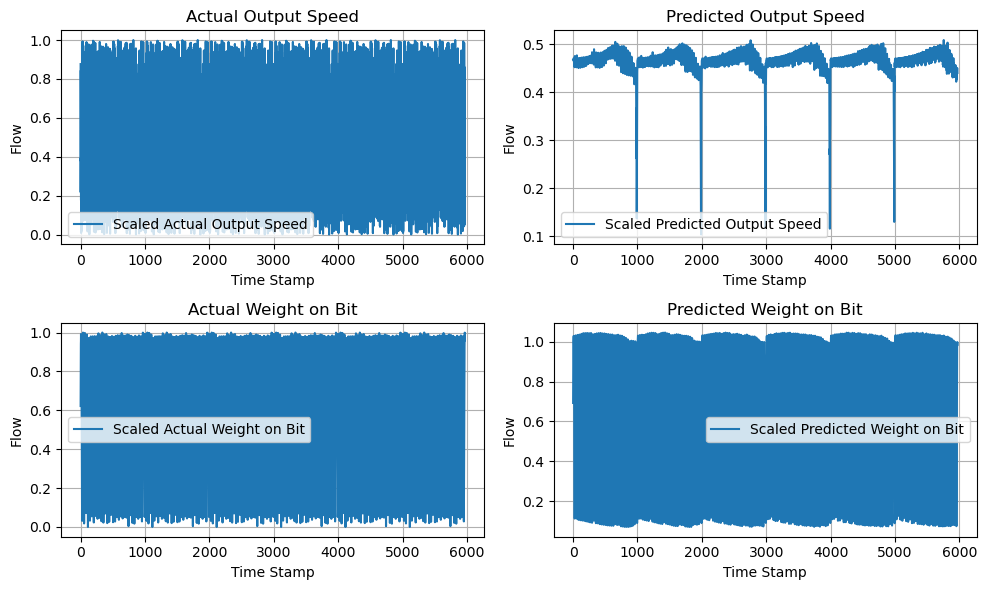

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize predictions and actual values storage
actual_data = []
predicted_data = []

for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
        predicted = model(x_batch).to('cpu').numpy()

    actual_data.append(y_batch.to('cpu').numpy())
    predicted_data.append(predicted)

# Convert lists to numpy arrays for plotting
actual_data = np.concatenate(actual_data, axis=0)
predicted_data = np.concatenate(predicted_data, axis=0)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# First subplot - Actual Output Speed
axs[0, 0].plot(actual_data[:, 0], label='Scaled Actual Output Speed')
axs[0, 0].set_title('Actual Output Speed')
axs[0, 0].set_xlabel('Time Stamp')
axs[0, 0].set_ylabel('Flow')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Second subplot - Predicted Output Speed
axs[0, 1].plot(predicted_data[:, 0], label='Scaled Predicted Output Speed')
axs[0, 1].set_title('Predicted Output Speed')
axs[0, 1].set_xlabel('Time Stamp')
axs[0, 1].set_ylabel('Flow')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Third subplot - Actual Weight on Bit
axs[1, 0].plot(actual_data[:, 1], label='Scaled Actual Weight on Bit')
axs[1, 0].set_title('Actual Weight on Bit')
axs[1, 0].set_xlabel('Time Stamp')
axs[1, 0].set_ylabel('Flow')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Fourth subplot - Predicted Weight on Bit
axs[1, 1].plot(predicted_data[:, 1], label='Scaled Predicted Weight on Bit')
axs[1, 1].set_title('Predicted Weight on Bit')
axs[1, 1].set_xlabel('Time Stamp')
axs[1, 1].set_ylabel('Flow')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


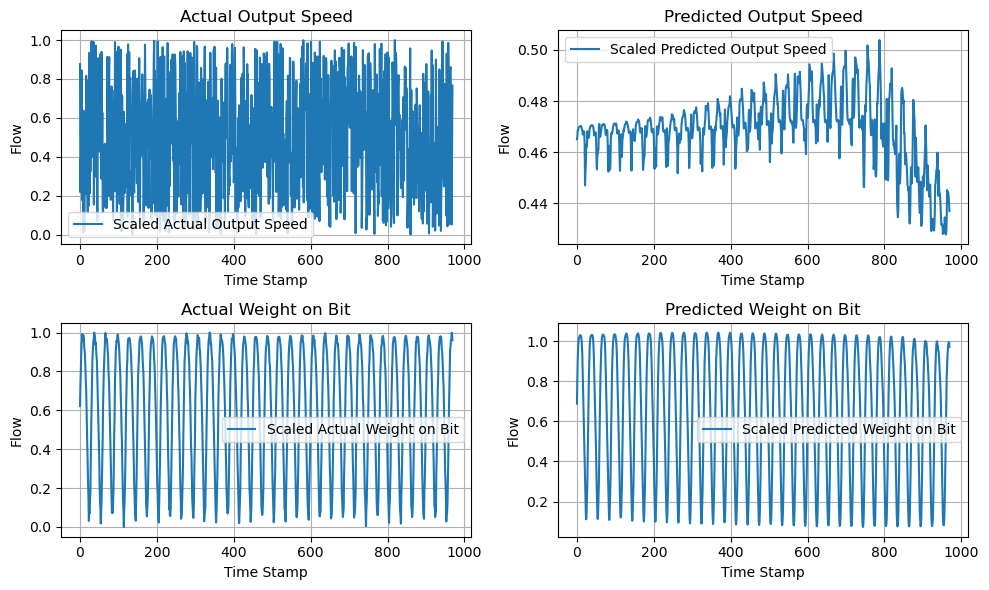

In [36]:

import matplotlib.pyplot as plt
import numpy as np

# Initialize predictions and actual values storage
actual_data = []
predicted_data = []

for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
        predicted = model(x_batch).to('cpu').numpy()

    actual_data.append(y_batch.to('cpu').numpy())
    predicted_data.append(predicted)

# Convert lists to numpy arrays for plotting
actual_data = np.concatenate(actual_data, axis=0)
predicted_data = np.concatenate(predicted_data, axis=0)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# First subplot - Actual Output Speed
axs[0, 0].plot(actual_data[:, 0], label='Scaled Actual Output Speed')
axs[0, 0].set_title('Actual Output Speed')
axs[0, 0].set_xlabel('Time Stamp')
axs[0, 0].set_ylabel('Flow')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Second subplot - Predicted Output Speed
axs[0, 1].plot(predicted_data[:, 0], label='Scaled Predicted Output Speed')
axs[0, 1].set_title('Predicted Output Speed')
axs[0, 1].set_xlabel('Time Stamp')
axs[0, 1].set_ylabel('Flow')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Third subplot - Actual Weight on Bit
axs[1, 0].plot(actual_data[:, 1], label='Scaled Actual Weight on Bit')
axs[1, 0].set_title('Actual Weight on Bit')
axs[1, 0].set_xlabel('Time Stamp')
axs[1, 0].set_ylabel('Flow')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Fourth subplot - Predicted Weight on Bit
axs[1, 1].plot(predicted_data[:, 1], label='Scaled Predicted Weight on Bit')
axs[1, 1].set_title('Predicted Weight on Bit')
axs[1, 1].set_xlabel('Time Stamp')
axs[1, 1].set_ylabel('Flow')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


## Loading the model and furnishing the output data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize predictions and actual values storage
actual_data = []
predicted_data = []

# Define the hyperparameters
input_size = 2
hidden_size = 70
num_stacked_layers = 3
output_size = 2

# Initialize the model
model = LSTMModel(input_size, hidden_size, num_stacked_layers, dropout=0.0, output_size=output_size)

model_path = "model (3).pth"

model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()


FileNotFoundError: [Errno 2] No such file or directory: 'model (3).pth'

In [ ]:
for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
        predicted = model(x_batch).to('cpu').numpy()

    actual_data.append(y_batch.to('cpu').numpy())
    predicted_data.append(predicted)

# Convert lists to numpy arrays for plotting
actual_data = np.concatenate(actual_data, axis=0)
predicted_data = np.concatenate(predicted_data, axis=0)

print("Actual_Data_shape", actual_data.shape, "Predicted_Data_shape", predicted_data.shape)

Actual_Data_shape (52970, 2) Predicted_Data_shape (52970, 2)


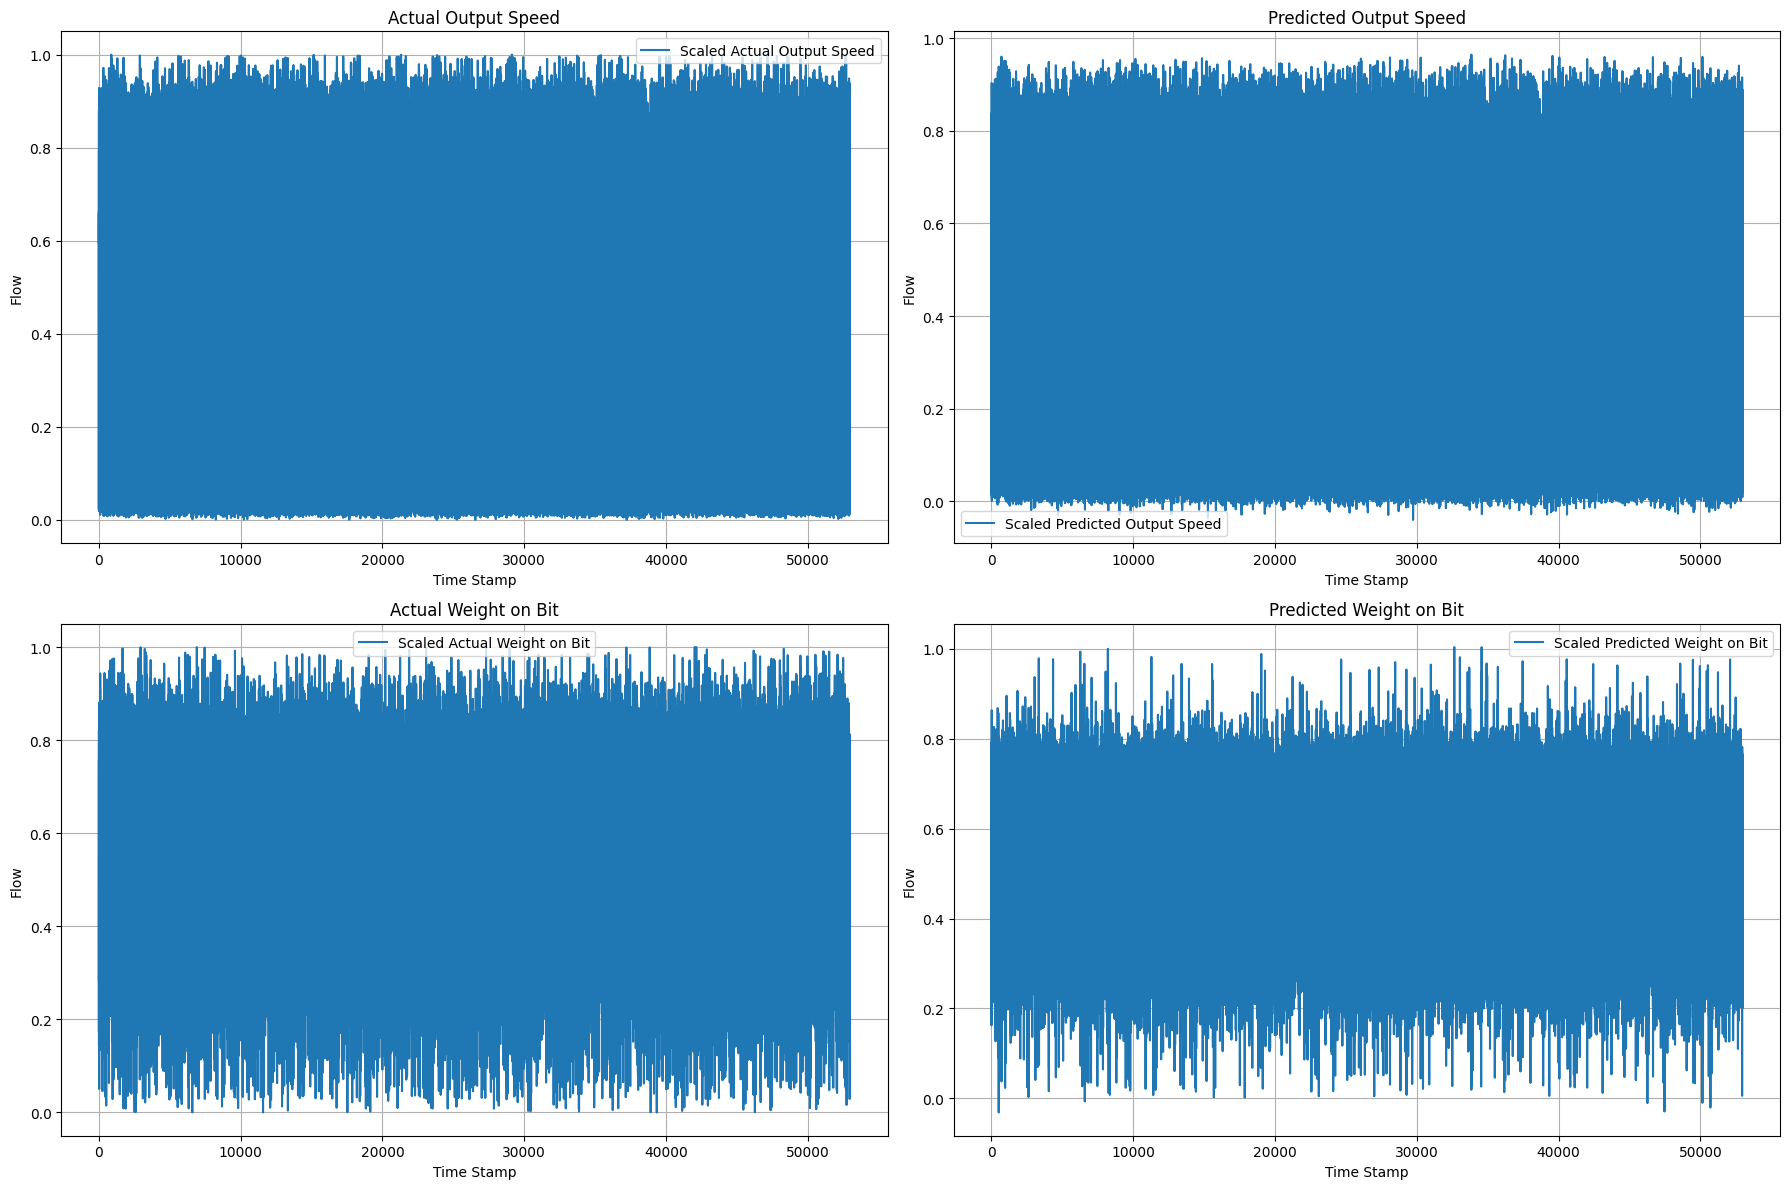

In [ ]:

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# First subplot - Actual Output Speed
axs[0, 0].plot(actual_data[:, 0], label='Scaled Actual Output Speed')
axs[0, 0].set_title('Actual Output Speed')
axs[0, 0].set_xlabel('Time Stamp')
axs[0, 0].set_ylabel('Flow')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Second subplot - Predicted Output Speed
axs[0, 1].plot(predicted_data[:, 0], label='Scaled Predicted Output Speed')
axs[0, 1].set_title('Predicted Output Speed')
axs[0, 1].set_xlabel('Time Stamp')
axs[0, 1].set_ylabel('Flow')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Third subplot - Actual Weight on Bit
axs[1, 0].plot(actual_data[:, 1], label='Scaled Actual Weight on Bit')
axs[1, 0].set_title('Actual Weight on Bit')
axs[1, 0].set_xlabel('Time Stamp')
axs[1, 0].set_ylabel('Flow')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Fourth subplot - Predicted Weight on Bit
axs[1, 1].plot(predicted_data[:, 1], label='Scaled Predicted Weight on Bit')
axs[1, 1].set_title('Predicted Weight on Bit')
axs[1, 1].set_xlabel('Time Stamp')
axs[1, 1].set_ylabel('Flow')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


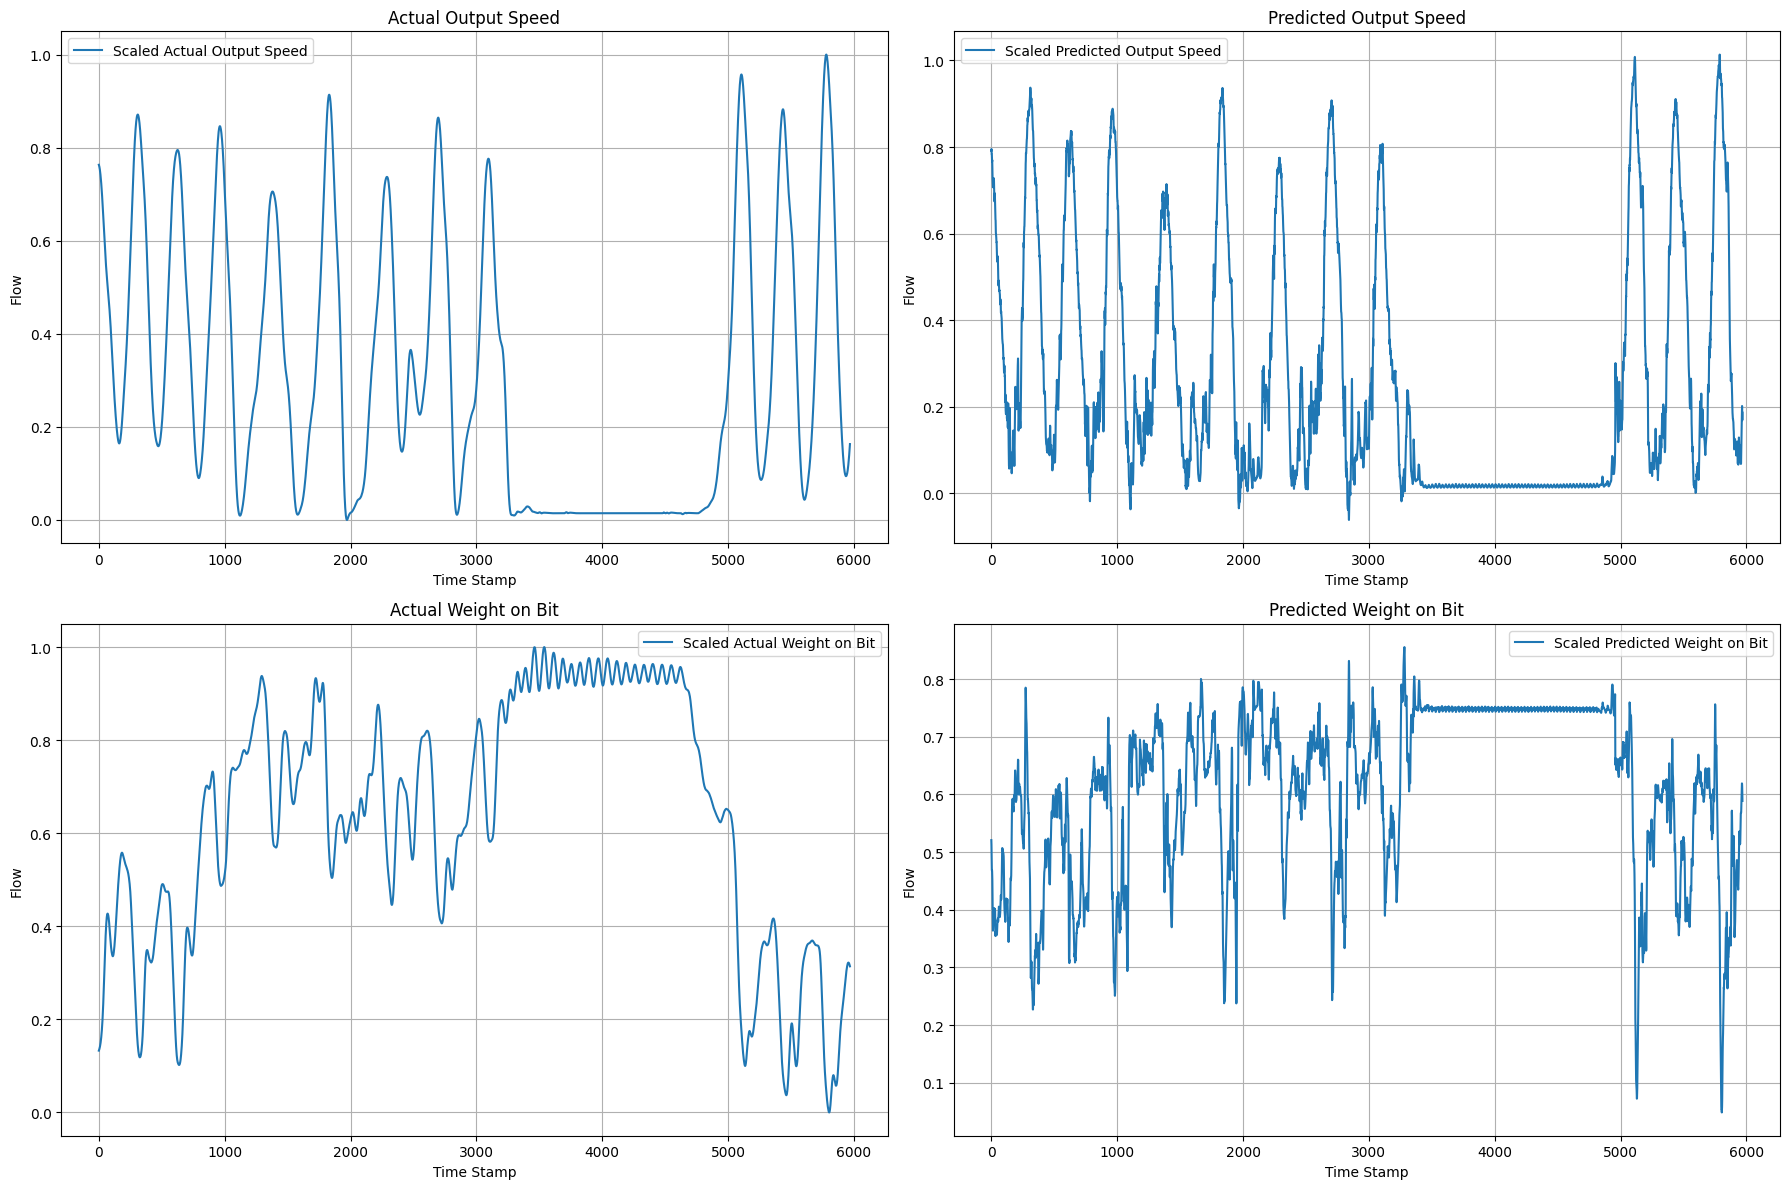

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize predictions and actual values storage
actual_data = []
predicted_data = []

for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
        predicted = model(x_batch).to('cpu').numpy()

    actual_data.append(y_batch.to('cpu').numpy())
    predicted_data.append(predicted)

# Convert lists to numpy arrays for plotting
actual_data = np.concatenate(actual_data, axis=0)
predicted_data = np.concatenate(predicted_data, axis=0)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# First subplot - Actual Output Speed
axs[0, 0].plot(actual_data[:, 0], label='Scaled Actual Output Speed')
axs[0, 0].set_title('Actual Output Speed')
axs[0, 0].set_xlabel('Time Stamp')
axs[0, 0].set_ylabel('Flow')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Second subplot - Predicted Output Speed
axs[0, 1].plot(predicted_data[:, 0], label='Scaled Predicted Output Speed')
axs[0, 1].set_title('Predicted Output Speed')
axs[0, 1].set_xlabel('Time Stamp')
axs[0, 1].set_ylabel('Flow')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Third subplot - Actual Weight on Bit
axs[1, 0].plot(actual_data[:, 1], label='Scaled Actual Weight on Bit')
axs[1, 0].set_title('Actual Weight on Bit')
axs[1, 0].set_xlabel('Time Stamp')
axs[1, 0].set_ylabel('Flow')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Fourth subplot - Predicted Weight on Bit
axs[1, 1].plot(predicted_data[:, 1], label='Scaled Predicted Weight on Bit')
axs[1, 1].set_title('Predicted Weight on Bit')
axs[1, 1].set_xlabel('Time Stamp')
axs[1, 1].set_ylabel('Flow')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()
